In [1]:
import os
import pandas as pd
import numpy as np

# Path to your dataset
DATA_PATH = '/kaggle/input/mitbih-database'
BEAT_WINDOW = 90  # beat length

# Beat classes
NORMAL_CLASSES = ['N']
ABNORMAL_CLASSES = ['L', 'R', 'V', 'A', 'F']

# Containers
X, y = [], []

# List CSV files
csv_files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith('.csv')])

for file in csv_files:
    record_id = file.replace('.csv', '')
    ann_file = os.path.join(DATA_PATH, f"{record_id}annotations.txt")

    # Skip if annotation not available
    if not os.path.exists(ann_file):
        continue

    # Load signal
    df_signal = pd.read_csv(os.path.join(DATA_PATH, file))
    signal = df_signal.iloc[:, 1].values  # assuming MLII or lead I

    # Load annotations
    annotations = []
    with open(ann_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 3 or parts[0].lower().startswith("time"):
                continue
            try:
                pos = int(parts[1])
                label = parts[2].strip()
                annotations.append((pos, label))
            except:
                continue

    # Segment around beat positions
    for pos, label in annotations:
        if label not in NORMAL_CLASSES + ABNORMAL_CLASSES:
            continue
        if pos - BEAT_WINDOW // 2 < 0 or pos + BEAT_WINDOW // 2 >= len(signal):
            continue
        beat = signal[pos - BEAT_WINDOW // 2 : pos + BEAT_WINDOW // 2]
        X.append(beat)
        y.append(0 if label in NORMAL_CLASSES else 1)

X = np.array(X)
y = np.array(y)

print(f"✅ Total beats: {len(X)} | Normal: {np.sum(y==0)} | Abnormal: {np.sum(y==1)}")


✅ Total beats: 100857 | Normal: 75045 | Abnormal: 25812


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


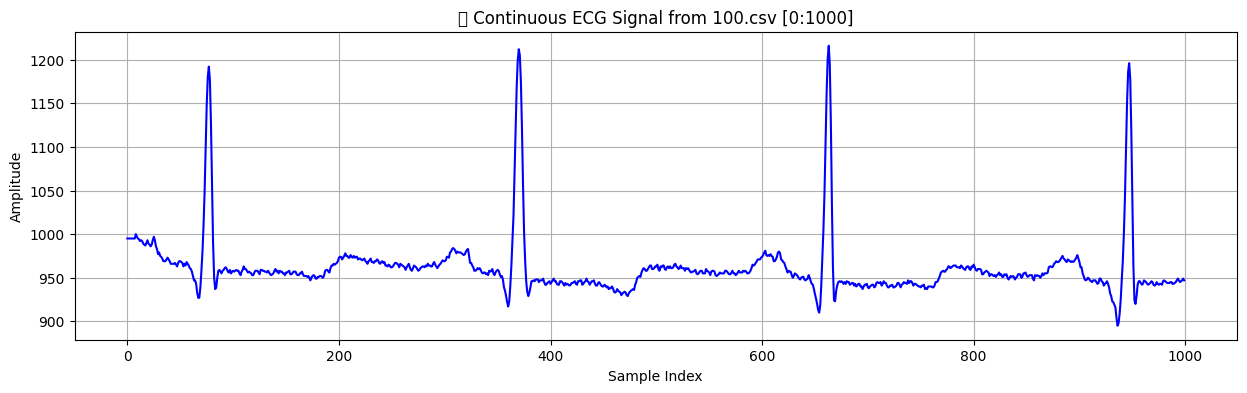

In [6]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# --- Load raw signal from one record ---
DATA_PATH = '/kaggle/input/mitbih-database'
file = '100.csv'  # You can change this to any record like '103.csv', etc.
record_path = os.path.join(DATA_PATH, file)

# Load the signal (skip header if needed)
df_signal = pd.read_csv(record_path)
signal = df_signal.iloc[:, 1].values  # Assuming second column is ECG

# --- Plot continuous signal segment ---
start = 0
window = 1000  # number of samples to view (e.g., 1000 = ~3-4 beats)

plt.figure(figsize=(15, 4))
plt.plot(signal[start:start+window], color='blue')
plt.title(f"📈 Continuous ECG Signal from {file} [{start}:{start+window}]")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


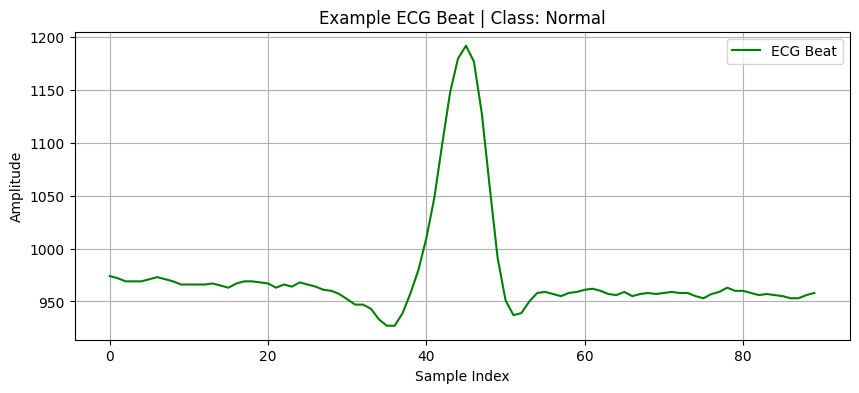

In [3]:
import matplotlib.pyplot as plt

idx = 0  # index of the beat
plt.figure(figsize=(10, 4))
plt.plot(X[idx], label="ECG Beat", color='green')
plt.title(f"Example ECG Beat | Class: {'Normal' if y[idx]==0 else 'Abnormal'}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


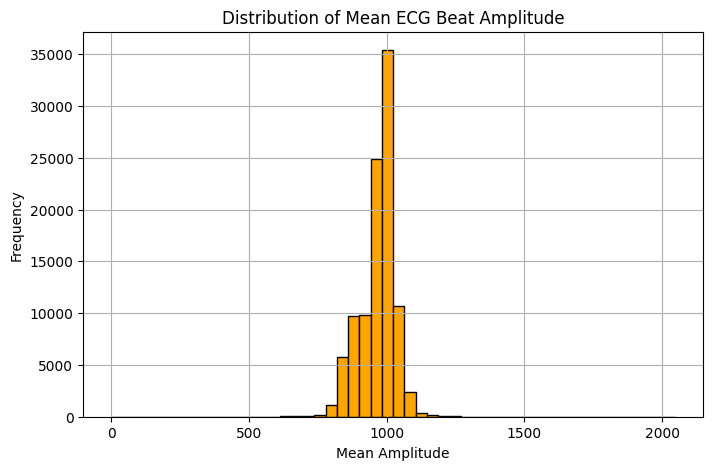

In [4]:
beat_means = X.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(beat_means, bins=50, color='orange', edgecolor='black')
plt.title("Distribution of Mean ECG Beat Amplitude")
plt.xlabel("Mean Amplitude")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


📉 Epoch 1/10 - Loss: 0.5619
📉 Epoch 2/10 - Loss: 0.1330
📉 Epoch 3/10 - Loss: 0.1191
📉 Epoch 4/10 - Loss: 0.1117
📉 Epoch 5/10 - Loss: 0.1010
📉 Epoch 6/10 - Loss: 0.0964
📉 Epoch 7/10 - Loss: 0.0924
📉 Epoch 8/10 - Loss: 0.0877
📉 Epoch 9/10 - Loss: 0.0848
📉 Epoch 10/10 - Loss: 0.0809


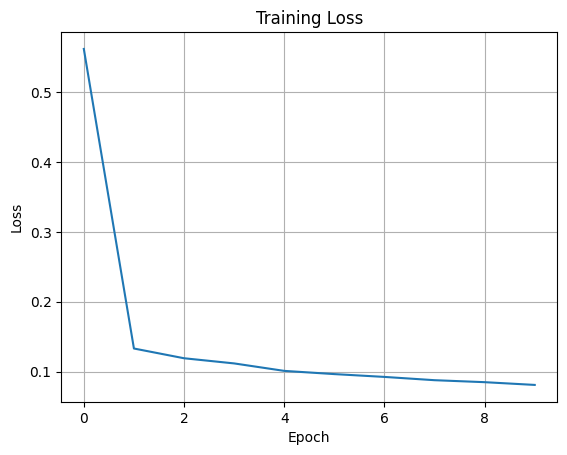

📊 Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      1.00      0.99     15009
    Abnormal       0.99      0.93      0.96      5163

    accuracy                           0.98     20172
   macro avg       0.98      0.96      0.97     20172
weighted avg       0.98      0.98      0.98     20172



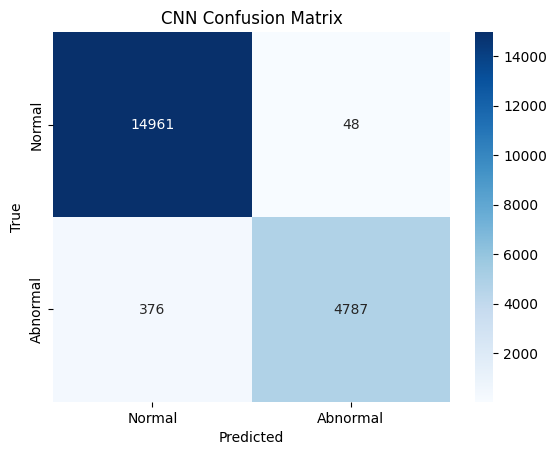

In [7]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Torch Dataset ---
X_train = torch.tensor(X_train).unsqueeze(1)  # shape: [B, 1, 90]
X_test  = torch.tensor(X_test).unsqueeze(1)
y_train = torch.tensor(y_train)
y_test  = torch.tensor(y_test)

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# --- CNN Model ---
class ECGClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        self.pool = nn.MaxPool1d(2)

        # Dynamically calculate flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, BEAT_WINDOW)  # [1, 1, 90]
            x = self.pool(F.relu(self.conv1(dummy)))  # → [1, 16, 43]
            x = self.pool(F.relu(self.conv2(x)))      # → [1, 32, 19]
            self.flattened_size = x.view(1, -1).shape[1]  # 32*19 = 608

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# --- Training ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECGClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"📉 Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# --- Plot Loss Curve ---
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Evaluation ---
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

print("📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"]))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.show()